# Import Libraries

In [168]:
import warnings
warnings.filterwarnings('ignore')
import time
import os
from tqdm.notebook import tqdm

import numpy as np 
import pandas as pd
import random


from PIL import Image
import cv2
import albumentations as A
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms as T
!pip install -q segmentation-models-pytorch
!pip install -q torchsummary
import segmentation_models_pytorch as smp
from torchsummary import summary

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [169]:
class Configs:
    '''Set values for parameters & variables'''
    
    ### General ###
    main_folder      = r'../input/semantic-drone-dataset/'
    num_classes      = pd.read_csv(main_folder + 'class_dict_seg.csv')['name'].nunique() - 1
    images_path      = main_folder + 'dataset/semantic_drone_dataset/original_images/'
    masks_path       = main_folder + 'dataset/semantic_drone_dataset/label_images_semantic/'
    images_count     = len(os.listdir(images_path))
    masks_count      = len(os.listdir(masks_path))
    num_bands        = 3 #RGB images
    device           = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed             = 100
    prediction_folder= r'../working/'  
    
    ### Data manegement ###
    test_size        = 0.1
    val_size         = 0.15
    batch_size       = 3
    train_val_count  = images_count - (test_size * images_count)
    val_size_count   = val_size * train_val_count
    
    ### Data Augmentation ###
    resize_height    = 704
    resize_width     = 1056
    normalize_mean   = (0.485, 0.456, 0.406)
    normalize_std    = (0.229, 0.224, 0.225)
    
    ### Model ###
    model_folder     = r'../working/'
    encoder_name     = 'mobilenet_v2'
    encoder_weights  = 'imagenet'
    decoder_channels = [256, 128, 64, 32, 16]
    encoder_depth    = len(decoder_channels)
    activation       = None
    model            = smp.Unet(encoder_name     = encoder_name,
                                encoder_weights  = encoder_weights,
                                classes          = num_classes,
                                encoder_depth    = encoder_depth,
                                decoder_channels = decoder_channels,
                                activation       = activation).to(device)
        
    ### Training ###
    epochs           = 10
    criterion        = nn.CrossEntropyLoss()
    max_lr           = 1e-3
    weight_decay     = 1e-4
    steps_per_epoch  = int((train_val_count - val_size_count) / batch_size)
    
    optimizer        = torch.optim.AdamW(params       = model.parameters(),
                                         lr           = max_lr,
                                         weight_decay = weight_decay)
    
    scheduler        = torch.optim.lr_scheduler.OneCycleLR(optimizer       = optimizer,
                                                           max_lr          = max_lr,
                                                           epochs          = epochs,
                                                           steps_per_epoch = steps_per_epoch)
    
    

In [170]:
print('Total images: ', Configs.images_count)
print('Total masks: ', Configs.masks_count)
print('Total classes in masks:', Configs.num_classes)

Total images:  400
Total masks:  400
Total classes in masks: 23


# Preprocessing

In [171]:
def create_df(path:str):
    name = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                name.append(file.split('.')[0])
    
    df = pd.DataFrame({'id_str': name}, index = np.arange(0, len(name)))
    df['id_int'] = df['id_str'].astype(int)
    
    return df


images_df = create_df(path = Configs.images_path)
masks_df   = create_df(path = Configs.masks_path)

Showing image ID: 31


<Figure size 432x288 with 0 Axes>

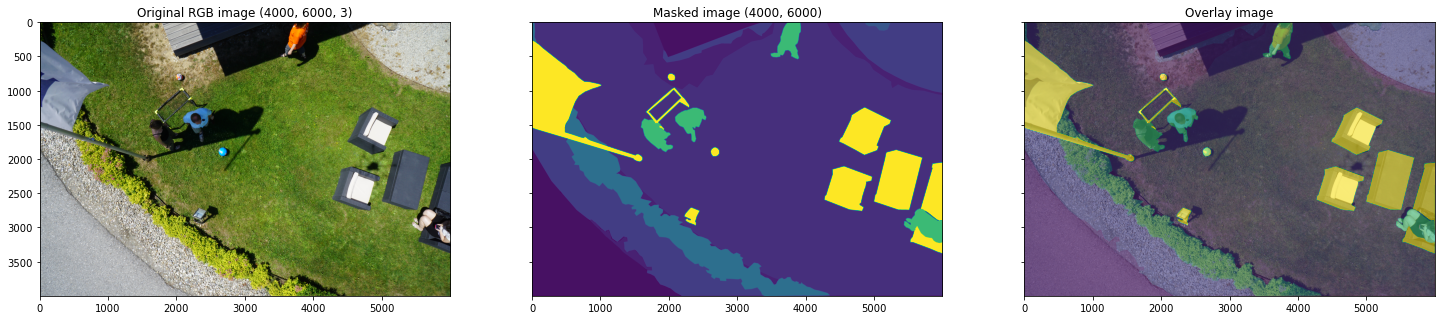

In [172]:
def plot_random_image():
    
    id_list = sorted(images_df['id_int'].values.tolist())
    random_id = random.choice(id_list)
    print(f'Showing image ID: {random_id}')
        
    image_id_str = images_df[images_df['id_int'] == random_id]['id_str'].item()
    random_image = Image.open(Configs.images_path + image_id_str + '.jpg')

    mask_id_str = masks_df[masks_df['id_int'] == random_id]['id_str'].item()
    random_mask = Image.open(Configs.masks_path + mask_id_str + '.png')

    plt.figure()
    fig, axarr = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(25, 25))

    axarr[0].imshow(random_image)
    axarr[0].set_title(f'Original RGB image {np.asarray(random_image).shape}')

    axarr[1].imshow(random_mask)
    axarr[1].set_title(f'Masked image {np.asarray(random_mask).shape}')

    axarr[2].imshow(random_image)
    axarr[2].imshow(random_mask, alpha=0.6)
    axarr[2].set_title('Overlay image')

    plt.show()




plot_random_image()

# Dataset

In [173]:
#split train data
X_train_val, X_test = train_test_split(images_df['id_str'].values,
                                       test_size = Configs.test_size,
                                       random_state = Configs.seed)

X_train, X_valid    = train_test_split(X_train_val,
                                       test_size = Configs.val_size,
                                       random_state = Configs.seed)

In [174]:
class TrainDataset(Dataset):
    
    def __init__(self, image_path : str,
                       mask_path  : str,
                       data,
                       augmentor         = None,
                       normalizer        = None):
        
        self.image_path = image_path    ;    self.mask_path = mask_path ;
        self.data = data                ;    self.augmentor = augmentor ;
        self.normalizer = normalizer    ;
        
    
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, idx):
        image = cv2.imread(self.image_path + self.data[idx] + '.jpg')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask  = cv2.imread(self.mask_path + self.data[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        
        if self.augmentor is not None:
            aug   = self.augmentor(image = image, mask = mask)
            #image = aug['image']
            image = Image.fromarray(aug['image'])
            mask  = aug['mask']
        
        elif self.augmentor is None:
            image = Image.fromarray(image)
            mask  = mask
            
        
        if self.normalizer is not None:
            image = self.normalizer(image)
            mask  = mask
        
        else:
            pass
        
        #mask = mask.long()
        mask = torch.from_numpy(mask).long()
        
        
        
        return image, mask
    

In [175]:
class TestDataset(Dataset):
    
    def __init__(self, image_path : str,
                       mask_path  : str,
                       data,
                       augmentor         = None,
                       normalizer        = None):
        
        self.image_path = image_path    ;    self.mask_path = mask_path ;
        self.data = data                ;    self.augmentor = augmentor ;
        self.normalizer = normalizer    ;
    
      
    
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, idx):
        image = cv2.imread(self.image_path + self.data[idx] + '.jpg')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask  = cv2.imread(self.mask_path + self.data[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
    
        if self.augmentor is not None:
            aug   = self.augmentor(image = image, mask = mask)
            #image = aug['image']
            image = Image.fromarray(aug['image'])
            mask  = aug['mask']
            mask  = torch.from_numpy(mask).long()

        elif self.augmentor is None:
            image = Image.fromarray(image)
            mask  = mask = torch.from_numpy(mask).long()
            
            
        if self.normalizer is not None:
            image = self.normalizer(image)
            mask  = mask
        
        else:
            pass
         
            #mask = mask.long()
        
        
        return image, mask

In [176]:
train_augmentor = A.Compose([
                             A.Resize(height = Configs.resize_height,
                                      width  =  Configs.resize_width,
                                      interpolation = cv2.INTER_NEAREST),
    
                             A.HorizontalFlip(),
    
                             A.VerticalFlip(),
    
                             A.GridDistortion(p = 0.2),
    
                             A.RandomBrightnessContrast(brightness_limit = (0,0.5),
                                                        contrast_limit = (0,0.5)),
                             A.GaussNoise()                     
                            ])



valid_augmentor = A.Compose([
                             A.Resize(height = Configs.resize_height,
                                      width  = Configs.resize_width,
                                      interpolation = cv2.INTER_NEAREST),
    
                             A.HorizontalFlip(),
    
                             A.GridDistortion(p = 0.2)
                            ])




test_augmentor = A.Compose([
                            A.Resize(height = Configs.resize_height,
                                     width  = Configs.resize_width,
                                     interpolation = cv2.INTER_NEAREST)
                           ])



normalizer_transform = T.Compose([
                                 T.ToTensor(),
                                 
                                 T.Normalize(Configs.normalize_mean,
                                             Configs.normalize_std)
                                 ])

In [177]:
train_set = TrainDataset(Configs.images_path, Configs.masks_path, X_train, train_augmentor, normalizer_transform)
val_set   = TrainDataset(Configs.images_path, Configs.masks_path, X_valid, valid_augmentor, normalizer_transform)
test_set  = TestDataset (Configs.images_path, Configs.masks_path, X_test,  test_augmentor,  normalizer_transform)



train_loader = DataLoader(train_set, batch_size = Configs.batch_size, shuffle = True)
val_loader   = DataLoader(val_set,   batch_size = Configs.batch_size, shuffle = True)



data_split_sizes = pd.DataFrame({'TotalImages'        : Configs.images_count,
                                 'TotalMasks'         : Configs.masks_count,
                                 'train_set'           : len(train_set),
                                 'val_set'            : len(val_set),
                                 'test_set'           : len(test_set),
                                 'train_loader_batch' : str(len(train_loader)) + ' x {}'.format(Configs.batch_size), #Should be equal to Configs.steps_per_epoch
                                 'val_loader_batch'   : str(len(val_loader)) + ' x {}'.format(Configs.batch_size)},
                                 index = ['Count'])


data_split_sizes

,TotalImages,TotalMasks,train_set,val_set,test_set,train_loader_batch,val_loader_batch
Count,400,400,306,54,40,102 x 3,18 x 3


# Training

Metrics

In [178]:
def pixel_accuracy(output, mask):
    '''
    Calculate the ratio betweeen the sum of for pixels thats were corrected
    in prediction mask.
    '''
    with torch.no_grad():
        output   = torch.argmax(F.softmax(output, dim = 1), dim = 1) #Get the location of pixel in predicted mask
        correct  = torch.eq(output, mask).int()                      #Comapare pixels between predicted mask and ground truth mask (= bool tensor of True's and False's)
        accuracy = float(correct.sum()) / float(correct.numel())     #Ratio between the sum of correct pixels and the count of all pixels in the mask
        
    return accuracy



def meanIoU(pred_mask, mask,
            num_classes:int = Configs.num_classes,
            smooth:bool = False):
    
    '''
    Calculates the mean overlap area between the predicted and ground truth segmentation maps
    and divides it by the sum of their areas.
    The IoU ranges from 0 (no overlap) to 1 (perfect overlap).
    '''
    
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim = 1)    
        pred_mask = torch.argmax(pred_mask, dim = 1)
        pred_mask = pred_mask.contiguous().view(-1)     #Flatten the prediced mask tensor
        mask      = mask.contiguous().view(-1)          #Flatten the truth mask tensor
 
        iou_per_class = []
    
        for clas in range(0, num_classes):              #loop per pixel class
            true_class = pred_mask == clas                 #output looks like: tensor([False, True, False, ..., False, False, False])
            true_label = mask == clas

            if true_label.long().sum().item() == 0:     # 0 meens theres no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union     = torch.logical_or(true_class, true_label).sum().float().item()
                
                if smooth:
                    smooth = 1e-10
                    iou = (intersect + smooth) / (union + smooth)
                else:
                    iou = intersect / union
                
                iou_per_class.append(iou)
                    
                
        
        meanIoU = np.nanmean(iou_per_class)            #Compute the mean of iou_per_class list while ignoring the None values
                
    return meanIoU

In [179]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [180]:
#summary(model      = Configs.model,
#        input_size = (Configs.num_bands, Configs.resize_height, Configs.resize_width),
#        batch_size = Configs.batch_size,
#        device     = str(Configs.device))

In [181]:
def fit(epochs:int, model, device, train_loader, val_loader, criterion, optimizer, scheduler, patch:bool = False):
    '''
    Defines a training loop.
    Returns dictionary with results.
    '''
    
    torch.cuda.empty_cache()
    
    #Training information to save from every loop
    train_losses     = []
    valid_losses     = []
    valid_IoUs       = []
    valid_accuracies = []
    train_IoUs       = []
    train_accuracies = []
    learn_rates      = []
    
    #Paramters being updated through training/validation
    min_loss     = np.inf
    decrease     = 1
    not_improve  = 0

    #configurations
    model.to(device)
    fit_time = time.time()
    print('Training started \n \n') 
    
    #Training loop
    for epoch in range(epochs):
        since = time.time()
        running_loss = 0
        IoU_score    = 0
        accuracy     = 0
        
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()
                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles  = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device)
            mask  = mask_tiles.to(device)
            
            #forward
            output = model(image)
            loss   = criterion(output, mask)
            #evaluation metrics
            IoU_score += meanIoU(output, mask)
            accuracy  += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step()      #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            learn_rates.append(get_lr(optimizer))
            scheduler.step()
            
            running_loss += loss.item()
            
        else:
            #Validation
            model.eval()
            valid_loss      = 0
            valid_accuracy  = 0
            valid_IoU_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles  = mask_tiles.view(-1, h, w)
                    
                    image  = image_tiles.to(device)
                    mask   = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    valid_IoU_score +=  meanIoU(output, mask)
                    valid_accuracy  += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    valid_loss += loss.item()
            
            #calculate mean for each batch
            train_losses.append(running_loss / len(train_loader))
            valid_losses.append(valid_loss / len(val_loader))


            if min_loss > (valid_loss / len(val_loader)):
                print('Loss Decreased by {:.3f}'.format(min_loss -  (valid_loss / len(val_loader))))
                min_loss = (valid_loss / len(val_loader))
                decrease += 1
                if decrease % 2 == 0:
                    print('saving model...')
                    torch.save(model, f'{Configs.model_folder}{Configs.model.name}.pt')


            if (valid_loss / len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (valid_loss / len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #Metrics
            valid_IoUs.append(valid_IoU_score / len(val_loader))
            train_IoUs.append(IoU_score / len(train_loader))
            train_accuracies.append(accuracy / len(train_loader))
            valid_accuracies.append(valid_accuracy / len(val_loader))
            
            print("Epoch:{}/{}   |"          .format(epoch + 1, epochs),
                  "Train Loss: {:.3f}   |"   .format(running_loss   /  len(train_loader)),
                  "Valid Loss: {:.3f}   |"   .format(valid_loss     /  len(val_loader)),
                  "Train meanIoU:{:.3f}   |" .format(IoU_score      /  len(train_loader)),
                  "Valid meanIoU: {:.3f}   |".format(valid_IoU_score/  len(val_loader)),
                  "Train Accuracy:{:.3f}   |".format(accuracy       /  len(train_loader)),
                  "Valid Accuracy:{:.3f}   |".format(valid_accuracy /  len(val_loader)),
                  "Time: {:.2f}m"            .format((time.time() - since) / 60))
        
        
    history = {'train_loss'       : train_losses,
               'valid_loss'       : valid_losses,
               'train_meanIoU'    : train_IoUs,
               'valid_meanIoU'    : valid_IoUs,
               'train_accuracies' : train_accuracies,
               'valid_accuracies' : valid_accuracies,
               'learn_rates'      : learn_rates}
    
    print('\n \n Training finished! \n Total time: {:.2f} minutes'.format((time.time() - fit_time) / 60))
    
    return history

In [182]:
history = fit(epochs       = Configs.epochs,
              model        = Configs.model,
              device       = Configs.device,
              train_loader = train_loader,
              val_loader   = val_loader,
              criterion    = Configs.criterion,
              optimizer    = Configs.optimizer,
              scheduler    = Configs.scheduler)

Training started 
 



  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreased by inf
saving model...
Epoch:1/5   | Train Loss: 2.397   | Valid Loss: 1.578   | Train meanIoU:0.079   | Valid meanIoU: 0.117   | Train Accuracy:0.402   | Valid Accuracy:0.593   | Time: 4.30m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreased by 0.381
Epoch:2/5   | Train Loss: 1.522   | Valid Loss: 1.198   | Train meanIoU:0.116   | Valid meanIoU: 0.136   | Train Accuracy:0.580   | Valid Accuracy:0.666   | Time: 4.31m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreased by 0.126
saving model...
Epoch:3/5   | Train Loss: 1.330   | Valid Loss: 1.071   | Train meanIoU:0.128   | Valid meanIoU: 0.159   | Train Accuracy:0.609   | Valid Accuracy:0.692   | Time: 4.30m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreased by 0.215
Epoch:4/5   | Train Loss: 1.141   | Valid Loss: 0.857   | Train meanIoU:0.155   | Valid meanIoU: 0.194   | Train Accuracy:0.667   | Valid Accuracy:0.752   | Time: 4.29m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreased by 0.003
saving model...
Epoch:5/5   | Train Loss: 1.052   | Valid Loss: 0.853   | Train meanIoU:0.175   | Valid meanIoU: 0.204   | Train Accuracy:0.701   | Valid Accuracy:0.749   | Time: 4.30m

 
 Training finished! 
 Total time: 21.50 minutes


In [183]:
saved_model = torch.load(Configs.model_folder + Configs.model.name + '.pt')

In [184]:
def plot_history(history):
    def plot_loss(history):
        plt.plot(history['valid_loss'], label ='Valid', marker = 'o')
        plt.plot(history['train_loss'], label ='Train', marker = 'o')
        plt.title('Loss per Epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(), plt.grid()
        plt.show()

    def plot_score(history):
        plt.plot(history['train_meanIoU'], label='Train meanIoU', marker='*')
        plt.plot(history['valid_meanIoU'], label='Valid meanIoU', marker='*')
        plt.title('Mean Intersect-over-Union per Epoch')
        plt.ylabel('Mean IoU')
        plt.xlabel('Epoch')
        plt.legend(), plt.grid()
        plt.show()

    def plot_accuracy(history):
        plt.plot(history['train_accuracies'], label='Train Accuracy', marker='*')
        plt.plot(history['valid_accuracies'], label='Valid Accuracy', marker='*')
        plt.title('Pixel Accuracy per Epoch')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(), plt.grid()
        plt.show()
        
    plot_loss(history)
    plot_score(history)
    plot_accuracy(history)

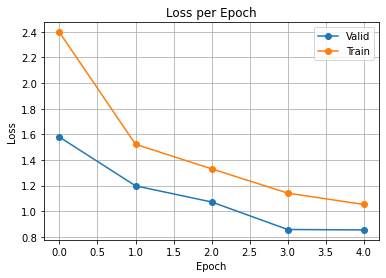

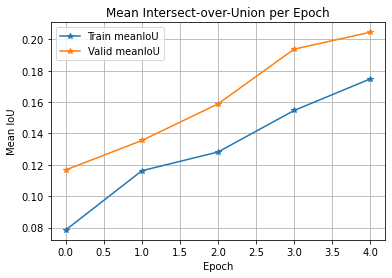

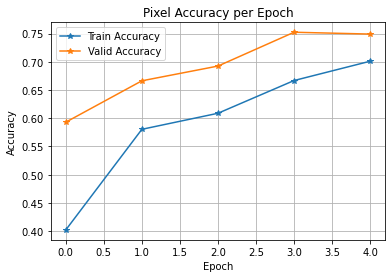

In [185]:
plot_history(history = history)

# Evaluation

In [ ]:
def predict_mask_miou(model, device, image, mask):
    model.eval()
    model = model.to(device)   ;    image = image.to(device)    ;    mask = mask.to(device)
    
    with torch.no_grad():
        image = image.unsqueeze(0)    ;    mask = mask.unsqueeze(0)
        
        output = model(image)
        score  = meanIoU(output, mask)
        
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
        
        
    return masked, score

In [269]:
from torchvision.utils import save_image


In [299]:
def predict_image_and_score(model, Dataset, device, output_path:str):
    
    '''
    Predict an image and returning the predicted mask, it's mean Intersect over Union score and it's Pixel Accuracy score.
    '''
    
    model.eval()
    model.to(device)
    
    meanIoU_scores        = []
    pixel_accuracy_scores = []
    
    for i in tqdm(range(1, Dataset.__len__())):
        model.eval()
        model.to(device)
        
        image = Dataset[i][0].to(device)              
        
        mask  = Dataset[i][1].to(device)
        
        
        with torch.no_grad():
            image = image.unsqueeze(0)
            
            mask = mask.unsqueeze(0)
            
            pred_mask            = model(image)
            meanIoU_score        = meanIoU(pred_mask, mask)
            pixel_accuracy_score = pixel_accuracy(pred_mask, mask)
            
            meanIoU_scores.append(meanIoU_score)
            pixel_accuracy_scores.append(pixel_accuracy_score)
            
            pred_mask = torch.argmax(pred_mask, dim=1)
            pred_mask = pred_mask.cpu().squeeze(0)
            plt.imsave(f'{output_path}{i}.png', pred_mask)
            
            
 
    
    metrics = pd.DataFrame({'Mean IoU'       : meanIoU_scores,
                            'Pixel Accuracy' : pixel_accuracy_scores})
    
    metrics['Image'] = metrics.index + 1
    
    
    
    return metrics

In [298]:
metrics = predict_image_and_score(model       = saved_model,
                                  Dataset     = test_set,
                                  device      = Configs.device,
                                  output_path = Configs.prediction_folder)


metrics[['Mean IoU', 'Pixel Accuracy']].mean()

  0%|          | 0/39 [00:00<?, ?it/s]

Mean IoU          0.223117
Pixel Accuracy    0.745693
dtype: float64

In [340]:
def plot_random_prediction(Dataset:Dataset, prediction_folder:str, metrics_df : pd.DataFrame = None):
    
    random_number = np.random.randint(1, Dataset.__len__())
    print(f'Showing observation number: {random_number}')
        
    random_image = Dataset[random_number][0]               ;        random_mask = Dataset[random_number][1] ;
    random_image = random_image.to('cpu').permute(1,2,0)   ;        random_mask = random_mask.to('cpu')     ;
    
    if metrics_df is not None:
        meanIoU = metrics_df[metrics_df['Image'] == random_number]['Mean IoU'].values
        Accuracy = metrics_df[metrics_df['Image'] == random_number]['Pixel Accuracy'].values
        
    else:
        pass
    
    pred_mask = Image.open(f'{prediction_folder}{random_number}.png')

    plt.figure()
    fig, axarr = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(25, 25))

    axarr[0].imshow(random_image)
    axarr[0].set_title(f'Original image {np.asarray(random_image).shape}')

    axarr[1].imshow(random_mask)
    axarr[1].set_title(f'Masked image {np.asarray(random_mask).shape}')

    axarr[2].imshow(pred_mask)
    if metrics_df is not None:
        axarr[2].set_title(f'Predicted mask image {np.asarray(random_mask).shape} \n with pixel accuracy:{Accuracy} & mean IoU: {meanIoU}')
    else:
         axarr[2].set_title(f'Predicted mask image {np.asarray(random_mask).shape}')

    plt.show();

Showing observation number: 1


<Figure size 432x288 with 0 Axes>

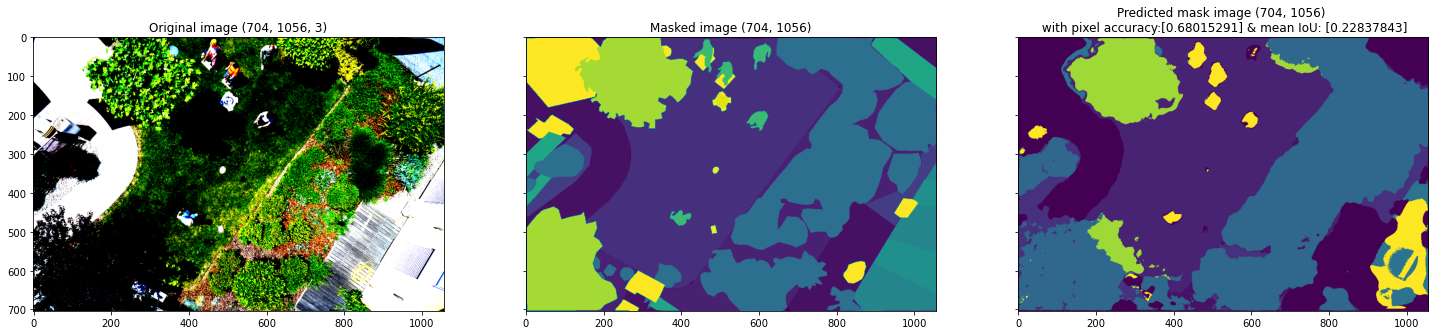

In [341]:
plot_random_prediction(Dataset = test_set, prediction_folder = Configs.prediction_folder, metrics_df = metrics);

Showing observation number: 2


<Figure size 432x288 with 0 Axes>

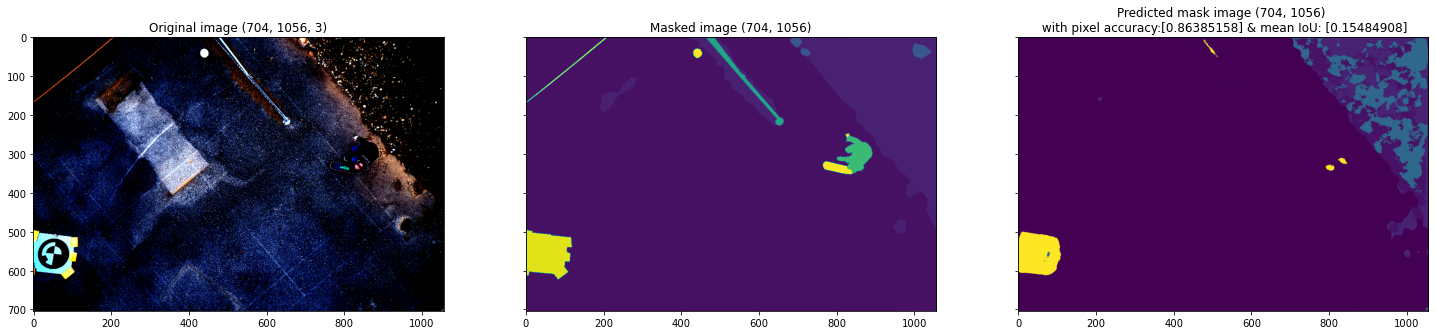

In [344]:
plot_random_prediction(Dataset = test_set, prediction_folder = Configs.prediction_folder, metrics_df = metrics);

Showing observation number: 13


<Figure size 432x288 with 0 Axes>

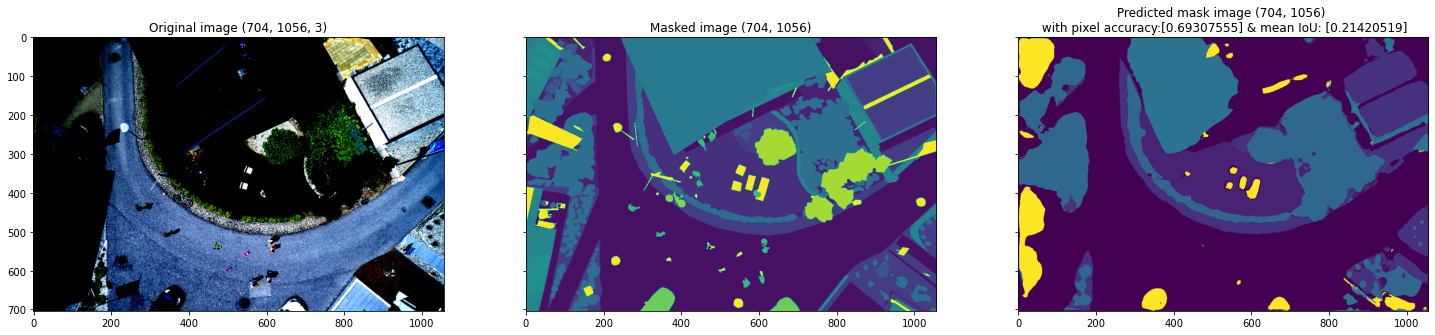

In [346]:
plot_random_prediction(Dataset = test_set, prediction_folder = Configs.prediction_folder, metrics_df = metrics);